* Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ
* Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения
* Попробуйте реализовать нейронную сеть архитектуры LSTM на numpy
* Предложите свои варианты решения проблемы исчезающего градиента в RNN

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import Dropout, Bidirectional
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
airline_passengers_data = pd.read_csv('airline-passengers.csv')

In [3]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Сформируем отдельные признаки года и месяца. Изначальный столбец даты удалим

In [4]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [5]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['month'] = months

    return df

In [6]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

In [7]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,month
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
 1   year        144 non-null    int64
 2   month       144 non-null    int64
dtypes: int64(3)
memory usage: 3.5 KB


Разбиение данных на тренировочную и валидационную выборки

In [9]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'month']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

In [10]:
# метки фичей и таргета
features = train_data.columns[1:]
target = train_data.columns[0]

In [11]:
# стандартизация
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,month
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Параметры для генерации выборки

In [290]:
# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.00001
batch_size = 8
epochs = 100

In [291]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

8 108
31 113


In [292]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (31, 2), (31,))

Визуализация данных

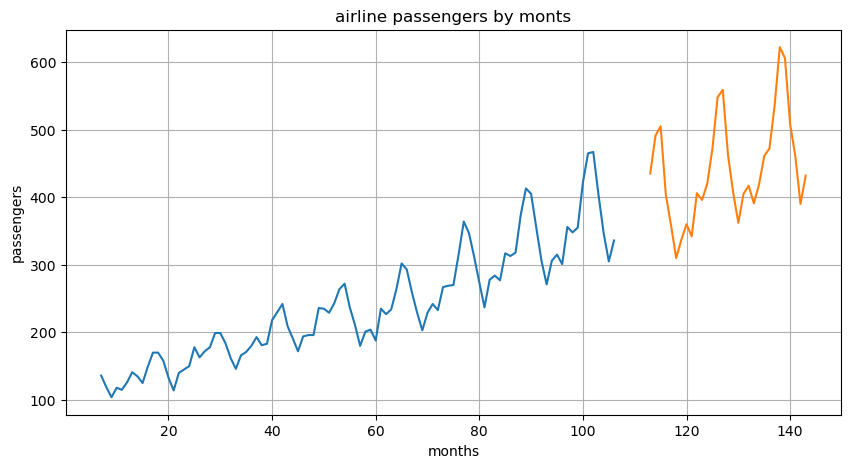

In [293]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

Приведение данных в формат тензора

In [294]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [295]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 7, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]
 [-1.52572369 -0.38515289]
 [-1.52572369 -0.09772536]
 [-1.52572369  0.18970217]
 [-1.52572369  0.4771297 ]], shape=(7, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(119, shape=(), dtype=int64)


Для получения наилучшего результата возьмём LSTM model

In [296]:
#контейнеры результатов
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

In [320]:
#Сборка модели
early_stop = EarlyStopping(monitor='val_mae', patience=3)

model_1 = Sequential()

model_1.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True))
model_1.add(LSTM(32, return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear', padding='same'))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(128, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 7, 32)             4480      
                                                                 
 lstm_136 (LSTM)             (None, 7, 32)             8320      
                                                                 
 conv1d_133 (Conv1D)         (None, 7, 64)             6208      
                                                                 
 conv1d_134 (Conv1D)         (None, 5, 64)             12352     
                                                                 
 conv1d_135 (Conv1D)         (None, 3, 64)             12352     
                                                                 
 flatten_64 (Flatten)        (None, 192)               0         
                                                                 
 dense_128 (Dense)           (None, 128)             

In [321]:
#обучение
history1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 7s 159ms/step - loss: 58470.5625 - mae: 229.5973 - val_loss: 188139.4531 - val_mae: 428.7779
Epoch 2/100
12/12 [==============================] - 0s 37ms/step - loss: 54846.6289 - mae: 222.3720 - val_loss: 172056.2344 - val_mae: 409.6140
Epoch 3/100
12/12 [==============================] - 0s 36ms/step - loss: 15481.4619 - mae: 119.8816 - val_loss: 9588.7529 - val_mae: 79.8285
Epoch 4/100
12/12 [==============================] - 0s 40ms/step - loss: 40935.5469 - mae: 151.2044 - val_loss: 29822.3555 - val_mae: 159.9723
Epoch 5/100
12/12 [==============================] - 0s 37ms/step - loss: 6669.0850 - mae: 73.8872 - val_loss: 5218.4648 - val_mae: 56.8397
Epoch 6/100
12/12 [==============================] - 0s 37ms/step - loss: 4541.5674 - mae: 59.2648 - val_loss: 15294.7910 - val_mae: 107.8549
Epoch 7/100
12/12 [==============================] - 0s 42ms/step - loss: 1669.4169 - mae: 33.5991 - val_loss: 4059.0376 - val_mae: 49.8545
E

12/12 [==============================] - 0s 40ms/step - loss: 273.0310 - mae: 12.9531 - val_loss: 1026.7524 - val_mae: 26.3425
Epoch 60/100
12/12 [==============================] - 0s 37ms/step - loss: 271.6457 - mae: 12.9206 - val_loss: 1017.7859 - val_mae: 26.2369
Epoch 61/100
12/12 [==============================] - 0s 38ms/step - loss: 270.2645 - mae: 12.8879 - val_loss: 1009.0145 - val_mae: 26.1312
Epoch 62/100
12/12 [==============================] - 0s 37ms/step - loss: 268.8887 - mae: 12.8550 - val_loss: 1000.4511 - val_mae: 26.0256
Epoch 63/100
12/12 [==============================] - 1s 47ms/step - loss: 267.5139 - mae: 12.8218 - val_loss: 992.1135 - val_mae: 25.9203
Epoch 64/100
12/12 [==============================] - 1s 45ms/step - loss: 266.1412 - mae: 12.7883 - val_loss: 983.9835 - val_mae: 25.8149
Epoch 65/100
12/12 [==============================] - 0s 37ms/step - loss: 264.7718 - mae: 12.7545 - val_loss: 976.0807 - val_mae: 25.7098
Epoch 66/100
12/12 [================

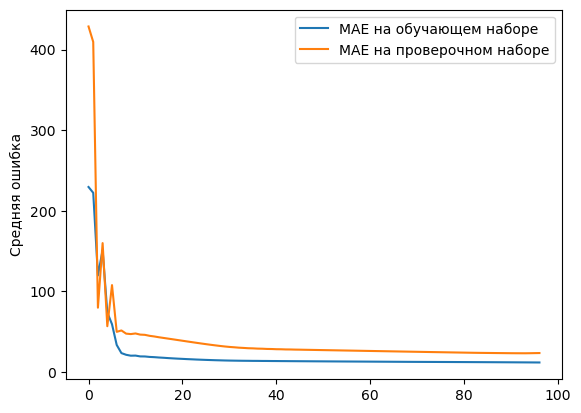

In [322]:
plt.plot(history1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Предсказания модели

In [323]:
pred1 = model_1.predict(dataset_train).flatten()
pred_val1 = model_1.predict(dataset_val).flatten()

4/4 [==============================] - 0s 13ms/step


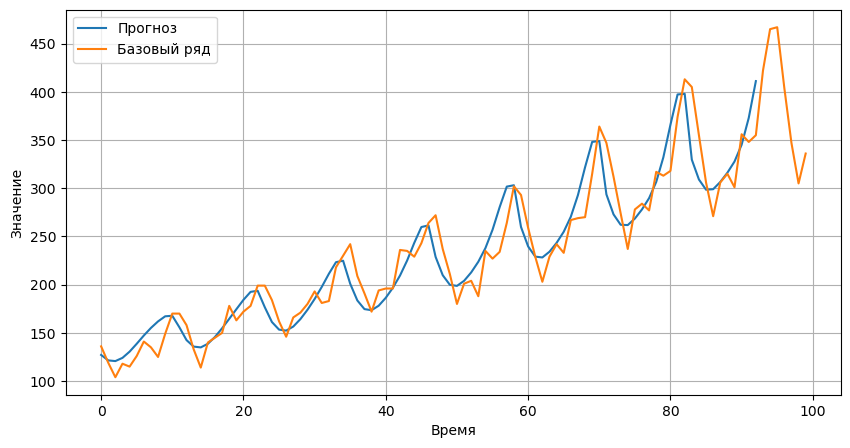

In [324]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [325]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

4/4 [==============================] - 0s 16ms/step - loss: 893.3521 - mae: 23.5452
train_loss: 191.91763305664062, train_m: 10.929368019104004
test_loss: 893.35205078125, test_m: 23.545236587524414


### Выводы:
* Для исследования выбрана модель LSTM
* Оптимальными параметрами стали: длина истории - 7, размер батча - 8, learning_rate = 0.00001
* Количество эпох для достижения оптимального результата - 100
* Модель LSTM была модифицирована: добавлены 3 свёрточных слоя Conv1D с количеством нейронов 64, линейной активацией и размером ядра - 3, которые постепенно сворачивали исходные данные. Для первого свёрточного слоя был применён параметр padding, для сохранения большего числа информации при передади на свёрточные слои
* Была также увеличена ширина плотного слоя сети до 128 нейронов. Это заставило уменьшить значение learning_rate для более стабильной работы
* При большем количестве эпох обучения модель либо перестаёт снижать контрольную ошибку, либо значение ошибки на тестовой выборке начинает расти, что говорит об переобучении    

### Предложите свои варианты решения проблемы исчезающего градиента в RNN
* Для решения проблемы исчезающего градиента в сетях типа RNN могут использоваться сети типа LSTM и GRU, в которых решена проблема затухания градиента благодаря наличию кандитаеного сигнала, который не затухает и изменяется посредством гейтов. 

### Генерация текста

In [2]:
# Читаем текст
data = open('sonnets.txt').read()
corpus = data.lower().split("\n")
corpus[:10]

['\tsonnets',
 '',
 '',
 '',
 'to the only begetter of',
 'these insuing sonnets',
 'mr. w. h. all happiness',
 'and that eternity',
 'promised by',
 'our ever-living poet wisheth']

In [3]:
# Создаем объект для токенизации
total_words = 1000
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(corpus)

In [4]:
print(corpus[0])
print(tokenizer.texts_to_sequences([corpus[2451]]))
print(tokenizer.word_index['from'], tokenizer.word_index['fairest'])

	sonnets
[[2, 134, 516, 13, 17, 457, 254, 69]]
34 418


In [5]:
# создадим последовательность токенов
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		sequence = token_list[:i+1]
		input_sequences.append(sequence)
input_sequences[:10]

[[3, 2],
 [3, 2, 313],
 [3, 2, 313, 4],
 [118, 878],
 [1, 8],
 [1, 8, 517],
 [126, 186],
 [126, 186, 278],
 [126, 186, 278, 635],
 [2, 98]]

In [6]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[:10]

11


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   2, 313],
       [  0,   0,   0,   0,   0,   0,   0,   3,   2, 313,   4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 118, 878],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   8],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   8, 517],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 126, 186],
       [  0,   0,   0,   0,   0,   0,   0,   0, 126, 186, 278],
       [  0,   0,   0,   0,   0,   0,   0, 126, 186, 278, 635],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  98]])

In [7]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)
label.shape

(12887, 1000)

Создание сети

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(Embedding(input_dim=total_words,
                    output_dim=1024,
                    input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(LSTM(1024))
model.add(Dropout(0.5))
model.add(Dense(total_words * 2, activation='relu'))
model.add(Dense(total_words * 4, activation='relu'))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 1024)          1024000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 10, 1024)         6295552   
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 10, 1024)         6295552   
 onal)                                                           
                                                                 
 lstm_23 (LSTM)              (None, 1024)              8392704   
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 2000)             

In [24]:
history = model.fit(predictors, label,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
323/323 [==============================] - 48s 105ms/step - loss: 6.0259 - accuracy: 0.0270 - val_loss: 5.8609 - val_accuracy: 0.0233
Epoch 2/100
323/323 [==============================] - 30s 94ms/step - loss: 5.7666 - accuracy: 0.0333 - val_loss: 5.9051 - val_accuracy: 0.0213
Epoch 3/100
323/323 [==============================] - 30s 94ms/step - loss: 5.6692 - accuracy: 0.0361 - val_loss: 5.9112 - val_accuracy: 0.0252
Epoch 4/100
323/323 [==============================] - 31s 97ms/step - loss: 5.5996 - accuracy: 0.0404 - val_loss: 5.9043 - val_accuracy: 0.0314
Epoch 5/100
323/323 [==============================] - 32s 99ms/step - loss: 5.5285 - accuracy: 0.0427 - val_loss: 5.9766 - val_accuracy: 0.0314
Epoch 6/100
323/323 [==============================] - 30s 93ms/step - loss: 5.4372 - accuracy: 0.0458 - val_loss: 6.1646 - val_accuracy: 0.0326
Epoch 7/100
323/323 [==============================] - 31s 96ms/step - loss: 5.3337 - accuracy: 0.0503 - val_loss: 6.2750 - val_a

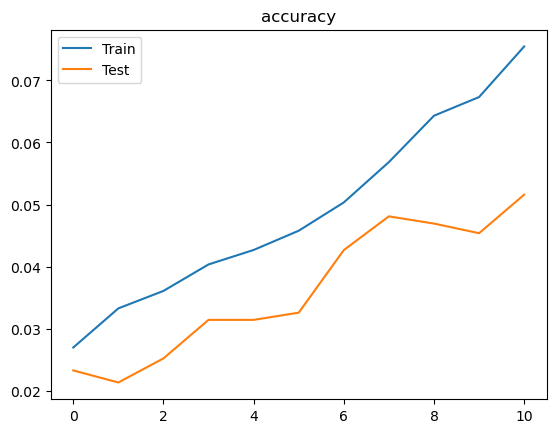

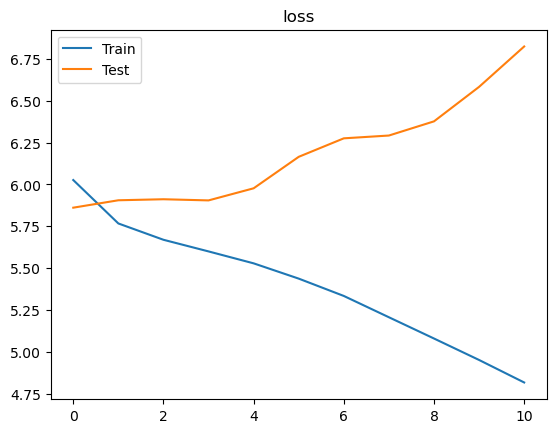

In [25]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train')
plt.plot(epochs, acc_v, label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, label='Train')
plt.plot(epochs, loss_v, label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [26]:
# seed_text = "Help me Obi Wan Kenobi, you're my only hope"
# seed_text = "She is my girl, I see in my hend"
seed_text = "To be, or not to be"
next_words = 10
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_proba = model.predict(token_list, verbose=0)
    predicted_classes = np.argmax(predicted_proba, axis=1)

    output_word = tokenizer.index_word[predicted_classes[0]]
    seed_text += " " + output_word
    
print(seed_text)

[3, 21, 36, 14, 3, 21]
[3, 21, 36, 14, 3, 21, 14]
[3, 21, 36, 14, 3, 21, 14, 14]
[3, 21, 36, 14, 3, 21, 14, 14, 21]
[3, 21, 36, 14, 3, 21, 14, 14, 21, 10]
[3, 21, 36, 14, 3, 21, 14, 14, 21, 10, 54]
[3, 21, 36, 14, 3, 21, 14, 14, 21, 10, 54, 14]
[3, 21, 36, 14, 3, 21, 14, 14, 21, 10, 54, 14, 8]
[3, 21, 36, 14, 3, 21, 14, 14, 21, 10, 54, 14, 8, 6]
[3, 21, 36, 14, 3, 21, 14, 14, 21, 10, 54, 14, 8, 6, 33]
To be, or not to be not not be thou art not that i do not


Выводы:
* Количество предсказываех классов очень высоко, поэтому получить приемлимый результат работы модели затруднительно
* обучение мрдели было прервано по критерию остановы

Изменения модели:
* увеличена выходная размерность эмбединга
* увеличено количество нейронов в бинаправленых LSTM слоях
* добавлен ещё один плотный слой нейросети
* количество настраиваимых параметров сети увеличено в 2 раза до 36 млн

Данные изменения сети не привели к значимым улучшениям результата её работы